In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
import os  

from numpy.polynomial.polynomial import polyfit

import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels

from census import Census # This is new...

In [2]:
url = "https://github.com/OpportunityInsights/EconomicTracker/raw/main/data/Affinity%20-%20County%20-%20Daily.csv"

df = pd.read_csv(url)

df["date"] = df.year.astype(str) + "-" + df.month.astype(str) + "-" + df.day.astype(str) 

df["date"] = pd.to_datetime(df["date"])

df.spend_all.replace('.',0, inplace = True)

df["spend_all"] = df["spend_all"].astype(float)

df.rename(columns = {"countyfips":"GEOFIPS"} ,inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,year,month,day,GEOFIPS,spend_all,date
0,2020,1,6,1001,0.0,2020-01-06
1,2020,1,6,1003,0.0,2020-01-06
2,2020,1,6,1009,0.0,2020-01-06
3,2020,1,6,1015,0.0,2020-01-06
4,2020,1,6,1019,0.0,2020-01-06


In [4]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7'
# This is my api_key

c = Census(my_api_key)
# This will create an object c which has methods associated with it.
# We will see  these below.

type(c) 
# Per the discussion below, try c.tab and see the options. 

code = ("NAME","B01001_001E","B19013_001E") 
# Same Codes: these are population and then median income (household?)

county_2018 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'county:*'}, year=2018))
                                         # Same deal, but we specify county then the wild card
                                         # On the example page, there are ways do do this, only by state
        
county_2018 = county_2018.rename(columns = {"B01001_001E":"2018_population", "B19013_001E":"2018_income"})

county_2018["GEOFIPS"] = (county_2018["state"] + county_2018["county"]).astype(int)

county_2018["2018_population"] = county_2018["2018_population"].astype(float)

county_2018["2018_income"] = county_2018["2018_income"].astype(float)

county_2018.dropna(inplace = True)

In [5]:
county_2018.head()

,NAME,2018_population,2018_income,state,county,GEOFIPS
0,"Washington County, Mississippi",47086.0,30834.0,28,151,28151
1,"Perry County, Mississippi",12028.0,39007.0,28,111,28111
2,"Choctaw County, Mississippi",8321.0,37203.0,28,019,28019
3,"Itawamba County, Mississippi",23480.0,40510.0,28,057,28057
4,"Carroll County, Mississippi",10129.0,43060.0,28,015,28015


In [6]:
covid_cases = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv")

nyc = covid_cases.county == "New York City"
covid_cases.loc[nyc,"fips"] = 36061
# A key issue is that New York City is a lumped together. 
# Below I'll apportion it to each county by population. a better way?

covid_cases["date"] = pd.to_datetime(covid_cases["date"], format = "%Y-%m-%d")

covid_cases.set_index("date",inplace = True)

endmonth = [dt.datetime(2020,5,31)]
# I'm just going to use the end of May count, this will be my exposre measure. 
# I think it's fine given how the initial wave all worked out, moving forward
# I need think a bit more about this...

covid_cases = covid_cases.loc[endmonth].reset_index()

covid_cases["date"] = pd.to_datetime(covid_cases["date"], format = "%Y-%m-%d") - pd.offsets.MonthBegin(1)

covid_cases["GEOFIPS"] = covid_cases["fips"]

In [7]:
df = df.merge(covid_cases[["cases", "GEOFIPS"]],
                                  left_on = ["GEOFIPS"], right_on = ["GEOFIPS"], how = "left")

In [8]:
df = df.merge(county_2018[["2018_income","2018_population", "GEOFIPS", "NAME"]],
                                  left_on = "GEOFIPS", right_on = "GEOFIPS", how = "left")

In [9]:
df["GEOFIPS"].dropna(inplace = True)

df["GEOFIPS"] = df["GEOFIPS"].astype(int)

In [10]:
df.set_index(["GEOFIPS", "date"], inplace = True)

In [11]:
nyc_counties = [36061,36081,36005,36085,36047]

nyc_all = df.loc[36061,"cases"].values[:].copy()
# what is strange about this is it's updating nyc_all in the 
#loop, this was not expected behavior...need the copy to keep fixed

idx = pd.IndexSlice

nyc_population = df.loc[idx[nyc_counties,dt.datetime(2020,2,1)],"2018_population"].sum()

for foo in nyc_counties:
    
    weight = df.loc[foo,"2018_population"].values[0]/nyc_population

    df.loc[foo,"cases"] = nyc_all*weight

In [12]:
df.head()

,,year,month,day,spend_all,cases,2018_income,2018_population,NAME
GEOFIPS,date,,,,,,,,
1001,2020-01-06,2020,1,6,0.0,221.0,58786.0,55200.0,"Autauga County, Alabama"
1003,2020-01-06,2020,1,6,0.0,290.0,55962.0,208107.0,"Baldwin County, Alabama"
1009,2020-01-06,2020,1,6,0.0,62.0,48695.0,57645.0,"Blount County, Alabama"
1015,2020-01-06,2020,1,6,0.0,160.0,45197.0,115098.0,"Calhoun County, Alabama"
1019,2020-01-06,2020,1,6,0.0,37.0,41014.0,25853.0,"Cherokee County, Alabama"


In [13]:
df = df[["spend_all", "2018_income", "2018_population", "cases", "NAME"]]

In [14]:
df.loc[36047]

,spend_all,2018_income,2018_population,cases,NAME
date,,,,,
2020-01-06,0.0000,56015.0,2600747.0,64092.235193,"Kings County, New York"
2020-01-07,0.0000,56015.0,2600747.0,64092.235193,"Kings County, New York"
2020-01-08,0.0000,56015.0,2600747.0,64092.235193,"Kings County, New York"
2020-01-09,0.0000,56015.0,2600747.0,64092.235193,"Kings County, New York"
2020-01-10,0.0000,56015.0,2600747.0,64092.235193,"Kings County, New York"
...,...,...,...,...,...
2020-08-05,-0.0770,56015.0,2600747.0,64092.235193,"Kings County, New York"
2020-08-06,-0.0697,56015.0,2600747.0,64092.235193,"Kings County, New York"
2020-08-07,-0.0623,56015.0,2600747.0,64092.235193,"Kings County, New York"


In [15]:
df["cases"] = df["cases"].fillna(0)

df["cases_pp"] = df["cases"]/df["2018_population"]

In [16]:
df.dropna(inplace = True)

In [17]:
calc = wc.Calculator("2018_population")

low = calc.quantile(df.xs('2020-02-07', level=1), "2018_income", 0.20)

high = calc.quantile(df.xs('2020-02-07', level=1), "2018_income", 0.80)

bins = [0, low, high, np.inf]
names = ['low', 'mid', 'high']

df["income_quintile"] = pd.cut(df["2018_income"], bins, labels=names)

In [18]:
df.head()

,,spend_all,2018_income,2018_population,cases,NAME,cases_pp,income_quintile
GEOFIPS,date,,,,,,,
1001,2020-01-06,0.0,58786.0,55200.0,221.0,"Autauga County, Alabama",0.004004,mid
1003,2020-01-06,0.0,55962.0,208107.0,290.0,"Baldwin County, Alabama",0.001394,mid
1009,2020-01-06,0.0,48695.0,57645.0,62.0,"Blount County, Alabama",0.001076,low
1015,2020-01-06,0.0,45197.0,115098.0,160.0,"Calhoun County, Alabama",0.001390,low
1019,2020-01-06,0.0,41014.0,25853.0,37.0,"Cherokee County, Alabama",0.001431,low


In [19]:
calc = wc.Calculator("2018_population")

covid_measure = "cases_pp"
threshold = -np.inf

non_zero = df.xs('2020-05-01', level=1)[covid_measure] > threshold

covid_low = calc.quantile(df.xs('2020-05-01', level=1)[non_zero], covid_measure, 0.20)

covid_high = calc.quantile(df.xs('2020-05-01', level=1)[non_zero], covid_measure, 0.80)

bins = [threshold, covid_low, covid_high, np.inf]

names = ['low', 'mid', 'high']

df["covid_quintile"] = pd.cut(df[covid_measure], bins, labels=names)

In [20]:
print("Median Income, Top Quintile: ", 
      round(df[df["income_quintile"] == "high"]["2018_income"].mean(),-2))

print("Median Income, Bottom Quintile: ", 
      round(df[df["income_quintile"] == "low"]["2018_income"].mean(),-2))

Median Income, Top Quintile:  89600.0
Median Income, Bottom Quintile:  43600.0


In [21]:
print("Median Income, Top Quintile: ", 
      round(df[df["covid_quintile"] == "high"]["cases_pp"].mean(),0))

print("Median Income, Bottom Quintile: ", 
      round(df[df["covid_quintile"] == "low"]["cases_pp"].mean(),0))

Median Income, Top Quintile:  0.0
Median Income, Bottom Quintile:  0.0


In [22]:
xs = df.xs('2020-02-07', level=1)

print("Population, Top Quintile: ", 
      round(xs[xs["income_quintile"] == "high"]["2018_population"].sum(),-2))

print("Population, Top Quintile: ", 
      round(xs[xs["income_quintile"] == "low"]["2018_population"].sum(),-2))

Population, Top Quintile:  57792600.0
Population, Top Quintile:  58045400.0


In [34]:
def plot_car_by_group(df,descrip):

    fig, ax = plt.subplots(figsize = (12,8))

    mike_blue = tuple(np.array([20, 64, 134]) / 255)
          
    foohigh = df.loc["high"].spend_all
        
    foomed = df.loc["mid"].spend_all
        
    foolow = df.loc["low"].spend_all
              
    label = 'Top Quintile Counties ' +  descrip 
    
    ax.plot(foohigh, alpha = 0.95, color = 'red', linewidth = 4, 
        label = label)
    
    label = 'Middle Quintile Counties ' + descrip 
        
    ax.plot(foomed, alpha = 0.45, color = "grey", linewidth = 4,
               label = label)

    label = 'Middle Quintile Counties ' + descrip 

    ax.plot(foolow, alpha = 0.65, color = mike_blue, linewidth = 4, 
        label = label)    
        
#######################################################################

#ax.fill_betweenx(1000,dt.datetime(2018,3,1),dt.datetime(2020,12,1), color = "#3F5D7D", alpha = 0.1)

    ax.axvspan(dt.datetime(2020,3,13),dt.datetime(2020,12,1), alpha=0.1, color="#3F5D7D")

    ax.set_xlim(dt.datetime(2020,1,1),dt.datetime(2020,9,1))

    ax.legend(loc = 0, frameon  = False, fontsize = 14)

    label_descrip = "Percent Change in Consumer Spending \n Relative to Jan 2020"
    ax.set_ylabel(label_descrip, fontsize = 14)

    ax.spines["right"].set_visible(False)

    ax.spines["top"].set_visible(False)

    ax.yaxis.grid(alpha= 0.5, linestyle= "--")

    ax.xaxis.grid(alpha= 0.5, linestyle= "--")

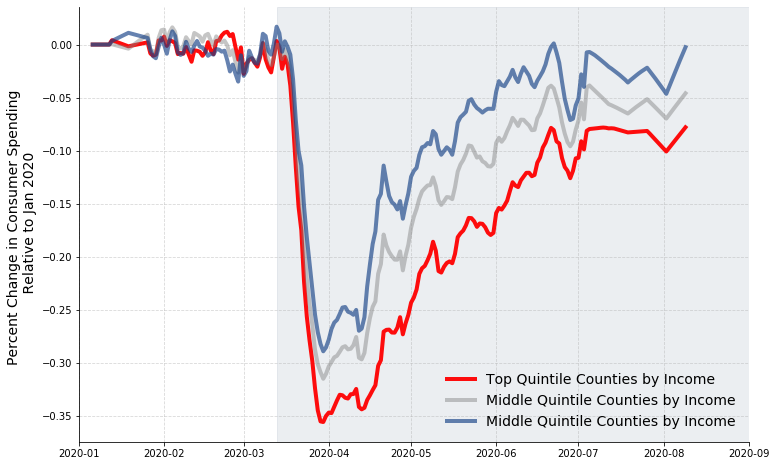

In [35]:
incgrp = df.groupby(["income_quintile", "date"])

spend_by_inc = incgrp.agg({"spend_all": "mean", "2018_population": "sum"})

plot_car_by_group(spend_by_inc, "by Income")

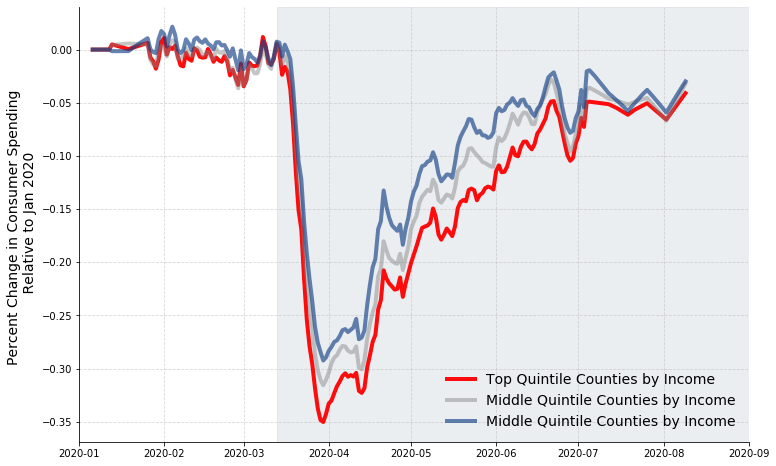

In [36]:
incgrp = df.groupby(["covid_quintile", "date"])

spend_by_cov = incgrp.agg({"spend_all": "mean", "2018_population": "sum"})

plot_car_by_group(spend_by_cov, "by Income")

In [37]:
df[df["covid_quintile"] == "low"]["cases"].mean()

64.61892247043365

In [38]:
df["joint_quintile"] = df["income_quintile"].astype(str) + "," + df["covid_quintile"].astype(str)

In [39]:
df.head()

,,spend_all,2018_income,2018_population,cases,NAME,cases_pp,income_quintile,covid_quintile,joint_quintile
GEOFIPS,date,,,,,,,,,
1001,2020-01-06,0.0,58786.0,55200.0,221.0,"Autauga County, Alabama",0.004004,mid,mid,"mid,mid"
1003,2020-01-06,0.0,55962.0,208107.0,290.0,"Baldwin County, Alabama",0.001394,mid,mid,"mid,mid"
1009,2020-01-06,0.0,48695.0,57645.0,62.0,"Blount County, Alabama",0.001076,low,low,"low,low"
1015,2020-01-06,0.0,45197.0,115098.0,160.0,"Calhoun County, Alabama",0.001390,low,mid,"low,mid"
1019,2020-01-06,0.0,41014.0,25853.0,37.0,"Cherokee County, Alabama",0.001431,low,mid,"low,mid"


In [40]:
def joint_plot(df,series,labels):

    fig, ax = plt.subplots(figsize = (12,8))

    mike_blue = tuple(np.array([20, 64, 134]) / 255)

    ax.plot(df.spend_all.loc[series[0]], alpha = 0.95, color = 'red', linewidth = 4, 
        label = labels[0])

    ax.plot(df.spend_all.loc[series[1]], alpha = 0.65, color = mike_blue, linewidth = 4, 
        label = labels[1])

#######################################################################

#ax.fill_betweenx(1000,dt.datetime(2018,3,1),dt.datetime(2020,12,1), color = "#3F5D7D", alpha = 0.1)

    ax.axvspan(dt.datetime(2020,3,1),dt.datetime(2020,12,1), alpha=0.1, color="#3F5D7D")

    ax.set_xlim(dt.datetime(2020,1,1),dt.datetime(2020,9,1))

    ax.legend(loc = 0, frameon  = False, fontsize = 14)

    label_descrip = "YoY % Change"

    ax.set_ylabel(label_descrip, fontsize = 14)

    ax.spines["right"].set_visible(False)

    ax.spines["top"].set_visible(False)

    ax.yaxis.grid(alpha= 0.5, linestyle= "--")

    ax.xaxis.grid(alpha= 0.5, linestyle= "--")

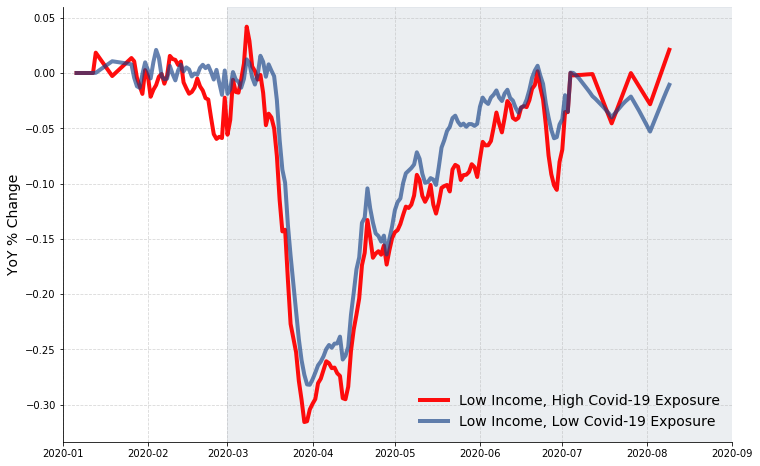

In [41]:
jntgrp = df.groupby(["joint_quintile", "date"])

spend_by_jnt = jntgrp.agg({"spend_all": "mean", "2018_population": "sum"})

label = ["Low Income, High Covid-19 Exposure", "Low Income, Low Covid-19 Exposure"]
series = ["low,high", "low,low"]

joint_plot(spend_by_jnt,series,label)

In [31]:
spend_by_jnt.head()

spend_all  2018_population
joint_quintile date                                  
high,high      2020-01-06        0.0       23018868.0
               2020-01-07        0.0       23018868.0
               2020-01-08        0.0       23018868.0
               2020-01-09        0.0       23018868.0
               2020-01-10        0.0       23018868.0